# Prediction models

In this notebook we try to implement different models that tries to predict the likes(log_like) score according to the garments you give as input. Outfits were extracted in a
previous preprocessing notebbok and we ended up with datasets that contains the image paths of cloths items in columns according to the category they belong. The last column is the log_like score 
we try to predict. 

We try different approaches using the Keras Functional Api with its high level capabilities for easier implementation. Everytime we import the data from the json files with the Outfit format
we have create. The models are:

1) The first model we try to implement is the model that uses encoder parts from autoencoders. Data go through the encoder to get embeddings and the output are given as inuts to the prediction model.The crucial part is tha the data for the prediction model has to be the same with the data given to autoencoders otherwise we dont get the proper results.

2) The second model is a classic implementation using CNN models one for each category image and then we try to display some results on Tops Bottoms and Shoes where Tops and Bottoms are used as anchors. 

3) In the last model we try to use tf tensors and tf datasets to import the data from the machine and drop numpy. when we preprocess and load the images tha machines crashes thats why we use fragments of data of 500 rows.

In [8]:
import pandas as pd
import string
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import tqdm
from PIL import Image
import cv2
%matplotlib inline

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.optimizers as optimizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras.models import load_model


## MODEL 1: We use the model that takes as input embeddings

In [ ]:
# Function for import and preprocessing images from paths
def preprocess_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

In [ ]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/image_paths_Outfits_Outerwear_Onepiece.json') as f:
    data1 = json.load(f)
df_image_paths = pd.DataFrame(data1)

In [ ]:
# Change the path of the images accoridingly to your dataset location
df_image_paths = df_image_paths.replace('/notebooks/', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/', regex=True)


In [ ]:
df_image_paths.head()

In [ ]:
y = df_image_paths["log_likes"].values
y.shape

In [ ]:
#We keep the categories here
categories = df_image_paths.columns[0:-1]
categories

In [ ]:
# getting the numpy values of the categories
df_image_paths_numpy = df_image_paths.iloc[:, 0:-1].values


In [ ]:
# Creates a vectorized version of our function 'preprocess_image_1' in order to apply it on each element of numpy array
vfunc = np.vectorize(preprocess_image_1, otypes=[np.ndarray])
df_images_numpy = vfunc(df_image_paths_numpy)

In [ ]:
# Extracting the categories of different clothes in arrays
Tops_array = df_images_numpy[:,0]
Bottoms_array = df_images_numpy[:,1]
Bags_array = df_images_numpy[:,2]
Outwear_array = df_images_numpy[:,3]
Shoes_array = df_images_numpy[:,4]
Accessories_array = df_images_numpy[:,5]


In [ ]:
# Loading the encoders Models
# Loading all the encoders models and load them to a dictionary of models with name the categoty of the encoder that it corresponds
categories = df_image_paths.columns[0:6]
# Initialize a dictionary to hold your models
models = {}
model_path = '/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/'

# Loop through each category
for category in categories:
    # Construct the file path
    model_path = f"/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/{category}_embedding_model.h5"
    if os.path.exists(model_path):
            # Load the model and store it in the dictionary
            models[category] = load_model(model_path)
            print(f"{category} model loaded successfully.")
    else:
            print(f"No model available for {category}, file does not exist.")


In [ ]:
####### IMPORTANT ##########
# Our arrays of the cloths have shape Tops_array.shape -->  (1973,) and the Tops_array[0] --> (64,64,3)
# Our input expects (batch_size, width, height, channels) or (1973,64,64,3) 
# To transform our dimensions and make it a 4D tensor we use np.stack

In [ ]:
####### IMPORTANT ##########
# Our arrays of the cloths have shape Tops_array.shape -->  (1973,) and the Tops_array[0] --> (64,64,3)
# Our input expects (batch_size, width, height, channels) or (1973,64,64,3) 
# To transform our dimensions and make it a 4D tensor we use np.stack
Tops_array_4D = np.stack(Tops_array, axis=0)
Bottoms_array_4D = np.stack(Bottoms_array, axis=0)
Bags_array_4D = np.stack(Bags_array, axis=0)
Outwear_array_4D = np.stack(Outwear_array, axis=0)
Shoes_array_4D = np.stack(Shoes_array, axis=0)
Accessories_array_4D = np.stack(Accessories_array, axis=0)

In [ ]:
Tops_array_4D.shape

In [ ]:
# Getting embeddigns on the images using the proper model encoder for each vector

Tops_embeddings = models['Tops'].predict(Tops_array_4D)
Bottoms_embeddings = models['Bottoms'].predict(Bottoms_array_4D)
Bags_embeddings = models['Bags'].predict(Bags_array_4D)
Outwear_embeddings = models['Outwear'].predict(Outwear_array_4D)
Shoes_embeddings = models['Shoes'].predict(Shoes_array_4D)
Accessories_embeddings = models['Accessories'].predict(Accessories_array_4D)

In [ ]:
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

In [ ]:
# Define the shape of your input images (height, width, channels)
input_shape = (16,)

In [ ]:
# We map here every layer to a specific input
#  the output from enbeddings models are used as input_shape of our multi input model

input_shape = (16,)
# Create seven input layers
input1 = Input(shape=input_shape, name="Embeddings_Tops")
input2 = Input(shape=input_shape, name="Embeddings_Bottom")
input3 = Input(shape=input_shape, name="Embeddings_Shoes")
input4 = Input(shape=input_shape, name="Embeddings_Bags")
input5 = Input(shape=input_shape, name="Embeddings_Accessories")
#input6 = Input(shape=input_shape, name="Embeddings_Onepiece")
input6 = Input(shape=input_shape, name="Embeddings_Oterwear")

fc1 = Dense(128, activation='relu')(input1)
fc2 = Dense(128, activation='relu')(input2)
fc3 = Dense(128, activation='relu')(input3)
fc4 = Dense(128, activation='relu')(input4)
fc5 = Dense(128, activation='relu')(input5)
fc6 = Dense(128, activation='relu')(input6)
#fc7 = Dense(128, activation='relu')(input7)

# Concatenate all the fully connected layers' outputs
concatenated = Concatenate()([fc1, fc2, fc3, fc4, fc5, fc6])


# Additional Fully Connected layer on concatenated outputs
fc_final1 = Dense(128, activation='linear')(concatenated)
fc_final2 = Dense(64, activation='relu')(fc_final1)
fc_final3 = Dense(32, activation='relu')(fc_final2)
fc_final4 = Dense(4, activation='relu')(fc_final3)
output = Dense(1,activation='linear')(fc_final4)

# We create the model with the inputs
model = Model(inputs=[input1,input2, input3, input4, input5, input6], outputs=output)

# Compile the model 
model.compile(optimizer= tensorflow.keras.optimizers.Adam(learning_rate=0.0001),
              loss='mean_squared_error')

#keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)



In [ ]:

history = model.fit(
    [Tops_embeddings,
     Bottoms_embeddings,
     Shoes_embeddings, 
     Bags_embeddings,
     Accessories_embeddings,
     Outwear_embeddings],
    y,
    epochs=100,
    batch_size=32,
    validation_split=0.1 # or use `validation_data=(X_val, y_val)` if you have separate validation data
)

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [ ]:
# Testing on some data from the dataset
outfit_index = 0  # Selecting the first outfit as an example

# Extract corresponding embeddings
single_top = Tops_embeddings[outfit_index]
single_bottom = Bottoms_embeddings[outfit_index]
single_bag = Bags_embeddings[outfit_index]
single_shoe = Shoes_embeddings[outfit_index]
single_accessory = Accessories_embeddings[outfit_index]
single_outerwear = Outwear_embeddings[outfit_index]

In [ ]:
single_top = np.reshape(single_top, (1, -1))
single_bottom = np.reshape(single_bottom, (1, -1))
single_bag = np.reshape(single_bag, (1, -1))
single_shoe = np.reshape(single_shoe, (1, -1))
single_accessory = np.reshape(single_accessory, (1, -1))
single_outerwear = np.reshape(single_outerwear, (1, -1))

In [ ]:
predicted_log_likes = model.predict(
    [single_top, single_bottom, single_shoe, single_bag, single_accessory, single_outerwear]
)
predicted_log_likes

## MODEL 2: Prediction model witn multiple CNN

In [30]:
def preprocess_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (224,224))
    im = im/255  
    return im

In [ ]:
with open('/notebooks/Recommendation_tool/image_paths_Outfits_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
df_image_paths = pd.DataFrame(data1)

In [4]:
# We use the first 500 rows 
df_image_paths=df_image_paths[:500]


In [34]:
# Getting the values from the dataframe
y = df_image_paths["log_likes"].values
# Reshape the target vector from (y,) -> (y,1)
y = y.reshape(-1, 1)
# Scale the target vector
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

In [36]:
categories = df_image_paths.columns[0:-1]
categories

Index(['Tops', 'Outwear', 'Bottoms', 'Shoes', 'Bags', 'Accessories'], dtype='object')

In [37]:
# Import the images from dataframe using the preprocessing function and store in lists one for each category
images_list_Tops = df_image_paths["Tops"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Bottoms = df_image_paths["Bottoms"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Shoes = df_image_paths["Shoes"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Bags = df_image_paths["Bags"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Accessories = df_image_paths["Accessories"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Outwear = df_image_paths["Outwear"].apply(lambda x: preprocess_image_1(x)).tolist()



# Convert list of preprocessed images to numpy array
images_array_Tops = np.stack(images_list_Tops)
images_array_Bottoms = np.stack(images_list_Bottoms)
images_array_Shoes = np.stack(images_list_Shoes)
images_array_Bags = np.stack(images_list_Bags)
images_array_Accessories = np.stack(images_list_Accessories)
images_array_Outwear = np.stack(images_list_Outwear)


In [38]:
images_array_Tops.shape

(500, 224, 224, 3)

In [9]:
# Function for the CNN model, it takes the image size as argument and the hidden layers size
def create_cnn(width, height, depth, filters=(128,64,32)):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# define the model input
	inputs = Input(shape=inputShape)
	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
  	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
	# if the regression node should be added
	# x = Dense(1, activation="linear")(x)
	# construct the CNN
	model = Model(inputs, x)
	# return the CNN
	return model

In [10]:
# uncomment if we want to use more category as input cloths. Initialy we use Tos, Bottoms and Shoes.
input_shape = (224,224,3)

# Create CNN models
cnn_tops = create_cnn(224, 224, 3)
cnn_bottoms = create_cnn(224, 224, 3)
cnn_shoes = create_cnn(224, 224, 3)
# cnn_bags = create_cnn(64, 64, 3, regress=True)
# cnn_accessories = create_cnn(64, 64, 3, regress=True)
# cnn_outerwear = create_cnn(64, 64, 3, regress=True)

# Image inputs
input1 = Input(shape=input_shape, name="Tops")
input2 = Input(shape=input_shape, name="Bottoms")
input3 = Input(shape=input_shape, name="Shoes")
# input4 = Input(shape=input_shape, name="Bags")
# input5 = Input(shape=input_shape, name="Accessories")
# input6 = Input(shape=input_shape, name="Outerwear")

# Getting embeddings from CNN models
embedding1 = cnn_tops(input1)
embedding2 = cnn_bottoms(input2)
embedding3 = cnn_shoes(input3)
# embedding4 = cnn_bags(input4)
# embedding5 = cnn_accessories(input5)
# embedding6 = cnn_outerwear(input6)

# Concatenate all the CNN outputs
concatenated = Concatenate()([embedding1, embedding2,embedding3])

# Additional Fully Connected layer on concatenated outputs
fc_final1 = Dense(128, activation='relu')(concatenated)
fc_final2 = Dense(64, activation='relu')(fc_final1)
fc_final3 = Dense(32, activation='relu')(fc_final2)
fc_final4 = Dense(4, activation='relu')(fc_final3)
output = Dense(1,activation='linear')(fc_final4)

# Final Model
model = Model(inputs=[input1, input2, input3], outputs=output)

opt = keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with regression loss
model.compile(loss='mse', optimizer=opt, metrics=['mean_absolute_error'])

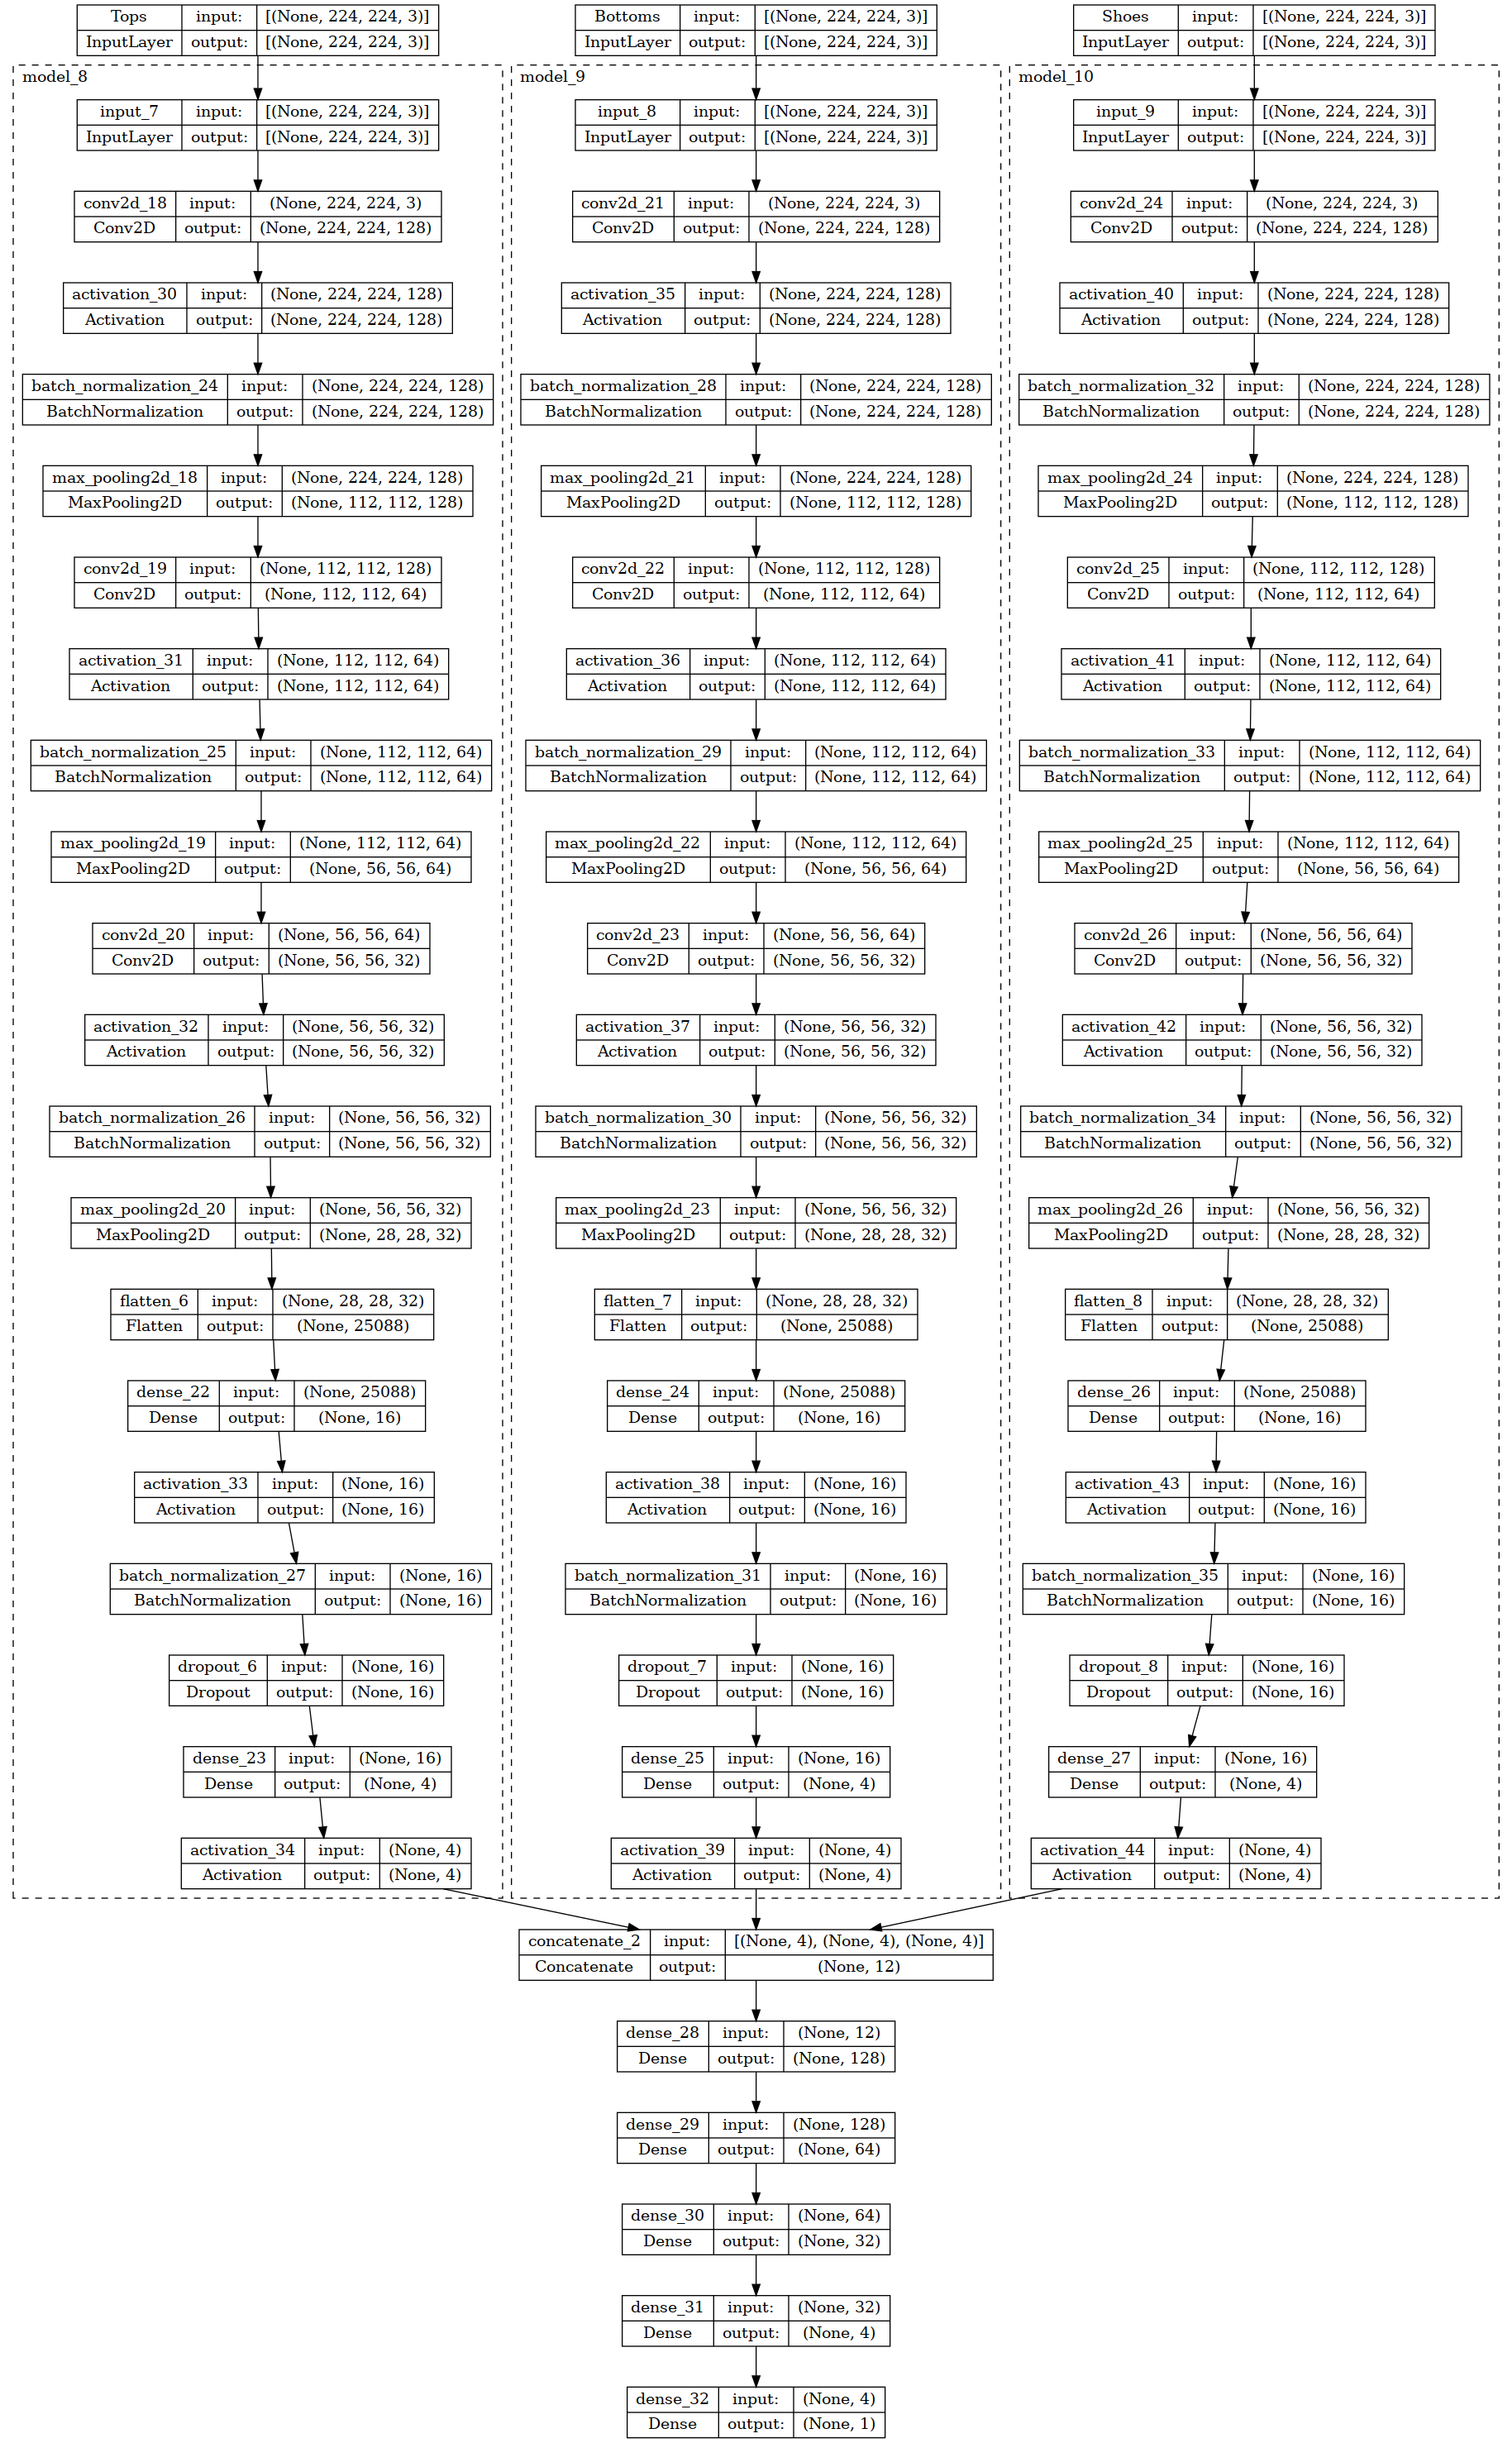

In [12]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)


In [41]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tops (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Bottoms (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Shoes (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                          

In [43]:

history = model.fit(
    [images_array_Tops,
     images_array_Bottoms,
     images_array_Shoes
    ],
    y_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.1 # or use `validation_data=(X_val, y_val)` if you have separate validation data
)

Epoch 1/20
15/15 [==============================] - 2s 117ms/step - loss: 0.8092 - mean_absolute_error: 0.6935 - val_loss: 1.0517 - val_mean_absolute_error: 0.8065
Epoch 2/20
15/15 [==============================] - 2s 102ms/step - loss: 0.7712 - mean_absolute_error: 0.6661 - val_loss: 1.0960 - val_mean_absolute_error: 0.8255
Epoch 3/20
15/15 [==============================] - 2s 103ms/step - loss: 0.7651 - mean_absolute_error: 0.6554 - val_loss: 1.0791 - val_mean_absolute_error: 0.8225
Epoch 4/20
15/15 [==============================] - 2s 101ms/step - loss: 0.7403 - mean_absolute_error: 0.6426 - val_loss: 1.0528 - val_mean_absolute_error: 0.8112
Epoch 5/20
15/15 [==============================] - 2s 101ms/step - loss: 0.7538 - mean_absolute_error: 0.6562 - val_loss: 1.0365 - val_mean_absolute_error: 0.8040
Epoch 6/20
15/15 [==============================] - 2s 101ms/step - loss: 0.7173 - mean_absolute_error: 0.6297 - val_loss: 1.0348 - val_mean_absolute_error: 0.7984
Epoch 7/20
15/15

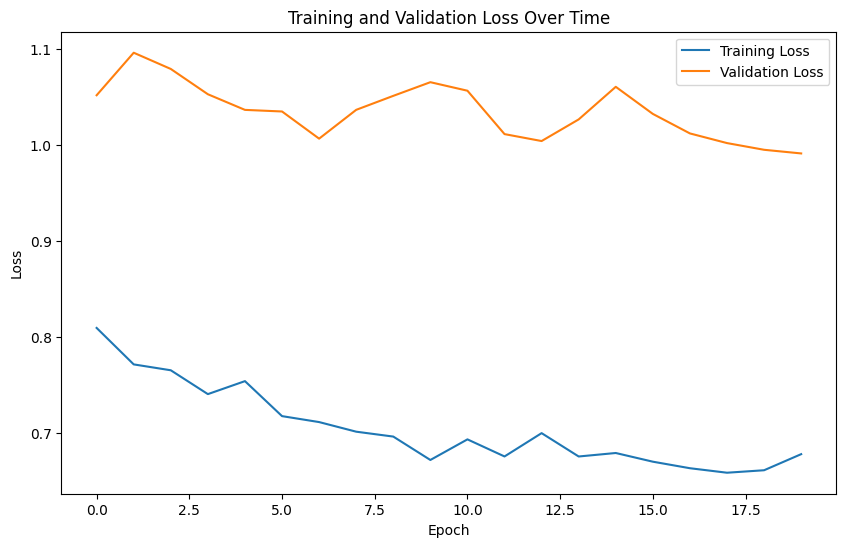

In [44]:
# Plotting the loss and validation_loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

## MODEL 3: Using model with tf dataset for better memory management

In [ ]:
# We try to use the tf.dataset and tensorflow tensors in order to help us with memory allocation problems. when we try to import hte images from paths of the data frame and save it to 
#lists and numpy arrays the machine crashes if we apply it on all the dataset thats why we used a fragment of the first 500 rows.

In [2]:
def preprocess_image_tf(im_path):
    img = tf.io.read_file(im_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
    img = img / 255.0
    return img

In [3]:
with open('/notebooks/Recommendation_tool/image_paths_Outfits_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
df_image_paths = pd.DataFrame(data1)

In [10]:
df_image_paths

,Tops,Outwear,Bottoms,Shoes,Bags,Accessories,log_likes
0,/notebooks/all_images/214181831_1.jpg,/notebooks/all_images/214181831_2.jpg,/notebooks/all_images/214181831_3.jpg,/notebooks/all_images/214181831_4.jpg,/notebooks/all_images/214181831_5.jpg,/notebooks/all_images/214181831_6.jpg,5.976351
1,/notebooks/all_images/143656996_1.jpg,/notebooks/all_images/143656996_2.jpg,/notebooks/all_images/143656996_3.jpg,/notebooks/all_images/143656996_4.jpg,/notebooks/all_images/143656996_5.jpg,/notebooks/all_images/143656996_6.jpg,3.465736
2,/notebooks/all_images/213824660_1.jpg,/notebooks/all_images/213824660_2.jpg,/notebooks/all_images/213824660_3.jpg,/notebooks/all_images/213824660_4.jpg,/notebooks/all_images/213824660_8.jpg,/notebooks/all_images/213824660_5.jpg,6.198479
3,/notebooks/all_images/152669888_1.jpg,/notebooks/all_images/152669888_2.jpg,/notebooks/all_images/152669888_3.jpg,/notebooks/all_images/152669888_4.jpg,/notebooks/all_images/152669888_5.jpg,/notebooks/all_images/152669888_8.jpg,5.356586
4,/notebooks/all_images/215196328_1.jpg,/notebooks/all_images/215196328_2.jpg,/notebooks/all_images/215196328_3.jpg,/notebooks/all_images/215196328_4.jpg,/notebooks/all_images/215196328_5.jpg,/notebooks/all_images/215196328_6.jpg,4.934474
...,...,...,...,...,...,...,...
1968,/notebooks/all_images/151650613_1.jpg,/notebooks/all_images/151650613_2.jpg,/notebooks/all_images/151650613_3.jpg,/notebooks/all_images/151650613_4.jpg,/notebooks/all_images/151650613_5.jpg,/notebooks/all_images/151650613_6.jpg,7.409742
1969,/notebooks/all_images/165632348_1.jpg,/notebooks/all_images/165632348_2.jpg,/notebooks/all_images/165632348_3.jpg,/notebooks/all_images/165632348_4.jpg,/notebooks/all_images/165632348_5.jpg,/notebooks/all_images/165632348_6.jpg,5.648974
1970,/notebooks/all_images/213826418_1.jpg,/notebooks/all_images/213826418_2.jpg,/notebooks/all_images/213826418_3.jpg,/notebooks/all_images/213826418_4.jpg,/notebooks/all_images/213826418_5.jpg,/notebooks/all_images/213826418_7.jpg,5.950643
1971,/notebooks/all_images/216860218_1.jpg,/notebooks/all_images/216860218_2.jpg,/notebooks/all_images/216860218_3.jpg,/notebooks/all_images/216860218_4.jpg,/notebooks/all_images/216860218_5.jpg,/notebooks/all_images/216860218_7.jpg,5.365976


In [4]:
y = df_image_paths["log_likes"].values
y

array([5.97635091, 3.4657359 , 6.19847872, ..., 5.95064255, 5.36597602,
       3.40119738])

In [5]:
# Assuming df is your dataframe and the columns are named with the respective clothing categories

paths_tops = df_image_paths['Tops'].tolist()
paths_bottoms = df_image_paths['Bottoms'].tolist()
paths_shoes = df_image_paths['Shoes'].tolist()
# ... similarly for other columns

dataset_tops = tf.data.Dataset.from_tensor_slices(paths_tops).map(preprocess_image_tf)
dataset_bottoms = tf.data.Dataset.from_tensor_slices(paths_bottoms).map(preprocess_image_tf)
dataset_shoes = tf.data.Dataset.from_tensor_slices(paths_shoes).map(preprocess_image_tf)
# ... similarly for other categories

# Zip the datasets together
dataset = tf.data.Dataset.zip((dataset_tops, dataset_bottoms, dataset_shoes))  # add other datasets

In [18]:
BATCH_SIZE = 32

dataset = dataset.shuffle(buffer_size=500)  # Assuming you're working with first 500 rows
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
test = dataset.take(1)

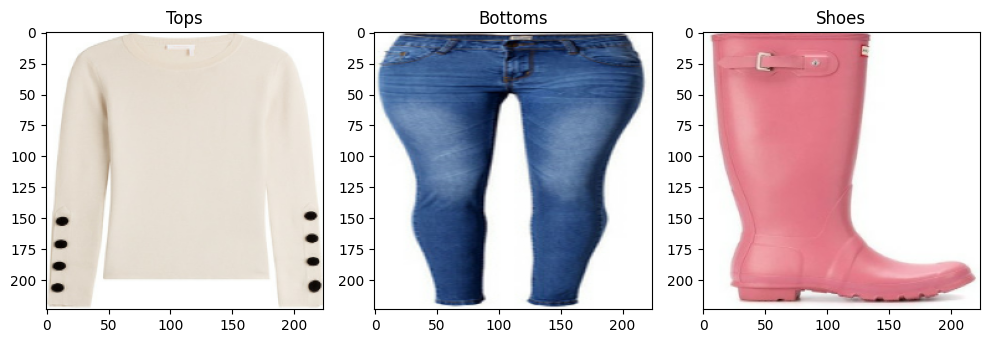

In [19]:
for batch in dataset.take(1):
    batch_tops, batch_bottoms, batch_shoes = batch

    # Assuming that the batch contains a set of images for each category

    # Visualize the first image from each category
    plt.figure(figsize=(10,5))

    plt.subplot(1,3,1)
    plt.imshow(batch_tops[0].numpy())
    plt.title("Tops")

    plt.subplot(1,3,2)
    plt.imshow(batch_bottoms[0].numpy())
    plt.title("Bottoms")

    plt.subplot(1,3,3)
    plt.imshow(batch_shoes[0].numpy())
    plt.title("Shoes")

    plt.tight_layout()
    plt.show()

In [20]:
test = batch_tops[0].numpy()

In [22]:
test.shape

(224, 224, 3)

In [ ]:
y = y.reshape(-1, 1)
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y)

In [ ]:
categories = df_image_paths.columns[0:6]
categories

In [3]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# define the model input
	inputs = Input(shape=inputShape)
	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
  	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
	# check to see if the regression node should be added
	# if regress:
	# 	x = Dense(1, activation="linear")(x)
	# construct the CNN
	model = Model(inputs, x)
	# return the CNN
	return model

In [5]:
input_shape = (224,224,3)

# Create CNN models
# We just unpack the input shape with starred expression
# cnn_tops = create_cnn(*input_shape)
# cnn_bottoms = create_cnn(*input_shape)
cnn_shoes = create_cnn(*input_shape)
# cnn_bags = create_cnn(64, 64, 3, regress=True)
# cnn_accessories = create_cnn(64, 64, 3, regress=True)
# cnn_outerwear = create_cnn(*input_shape)
cnn_onepiece= create_cnn(*input_shape)


# Image inputs
# input1 = Input(shape=input_shape, name="Tops")
# input2 = Input(shape=input_shape, name="Bottoms")
input3 = Input(shape=input_shape, name="Shoes")
# input4 = Input(shape=input_shape, name="Bags")
# input5 = Input(shape=input_shape, name="Accessories")
# input6 = Input(shape=input_shape, name="Outerwear")
input7 = Input(shape=input_shape, name="Onepiece")

# Getting embeddings from CNN models
# embedding1 = cnn_tops(input1)
# embedding2 = cnn_bottoms(input2)
embedding3 = cnn_shoes(input3)
# embedding4 = cnn_bags(input4)
# embedding5 = cnn_accessories(input5)
# embedding6 = cnn_outerwear(input6)
embedding7 = cnn_onepiece(input7)


# Concatenate all the CNN outputs
concatenated = Concatenate()([embedding3,embedding7])

# Additional Fully Connected layer on concatenated outputs
fc_final1 = Dense(128, activation='relu')(concatenated)
fc_final2 = Dense(64, activation='relu')(fc_final1)
fc_final3 = Dense(32, activation='relu')(fc_final2)
fc_final4 = Dense(4, activation='relu')(fc_final3)
output = Dense(1,activation='linear')(fc_final4)

# Final Model
model = Model(inputs=[ input3,input7], outputs=output)

opt = keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model with regression loss
model.compile(loss='mse', optimizer=opt, metrics=['mean_absolute_error'])

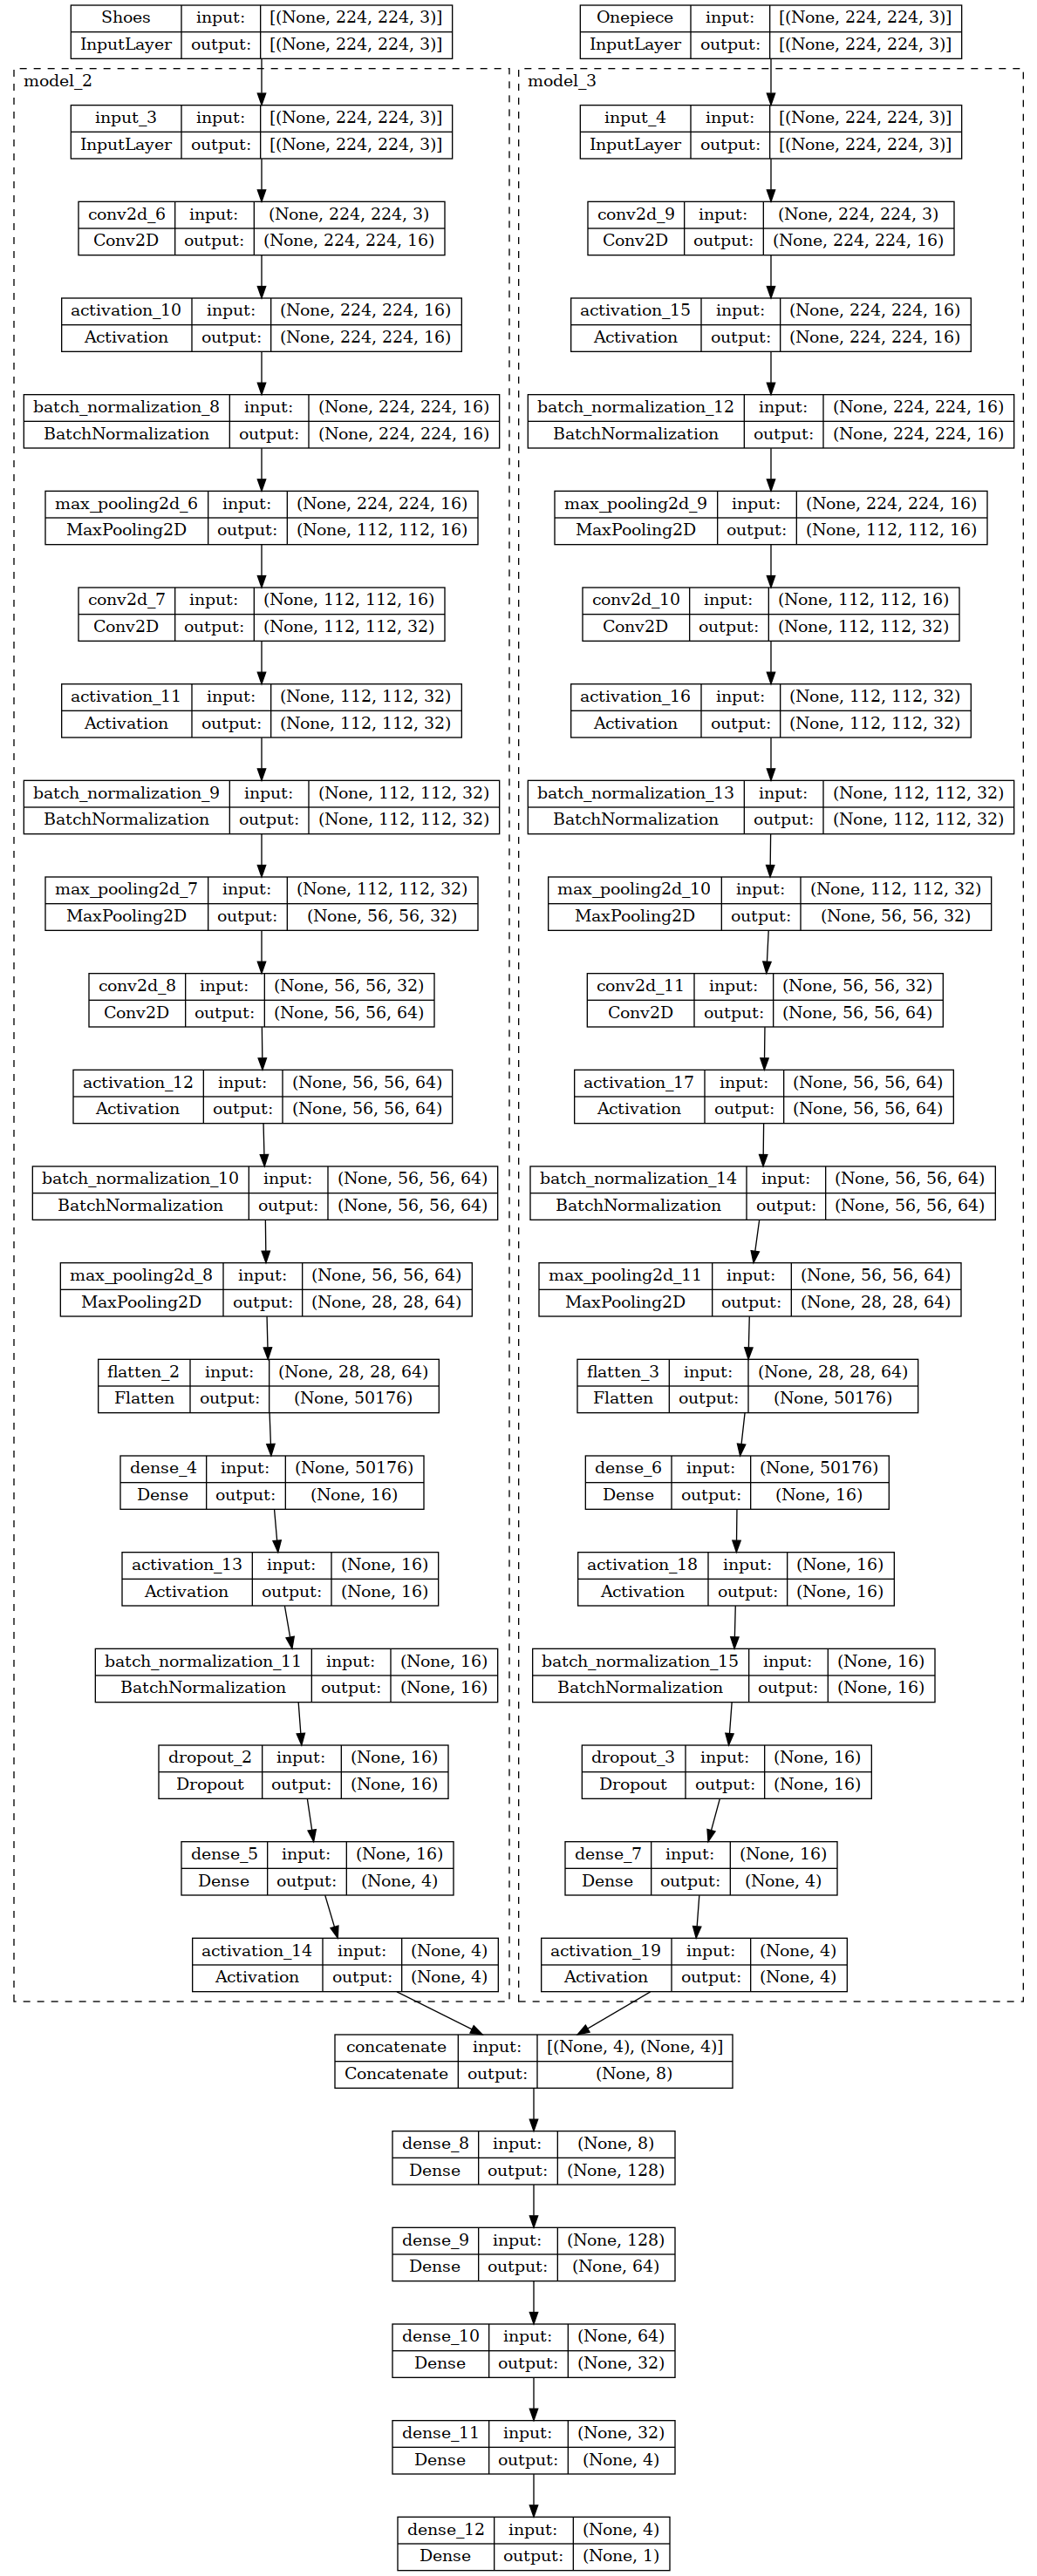

In [6]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)


In [7]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Shoes (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Onepiece (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 4)            826996      ['Shoes[0][0]']                  
                                                                                            

In [ ]:
history = model.fit(
    [images_array_Tops,
     images_array_Bottoms,
     images_array_Shoes
    ],
    y_scaled,
    epochs=20,
    batch_size=32,
    validation_split=0.1 # or use `validation_data=(X_val, y_val)` if you have separate validation data
)

In [7]:
len(os.listdir('/notebooks/polyvore_1000_cleaned/Accessories'))

809

## MODEL 4: Making model with flags

In [17]:
def preprocess_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (224,224))
    im = im/255  
    return im

In [18]:
with open('/home/thanos/Desktop/Sustainable_fashion/repos/Recommendation_tool/data/image_paths_Outfits_Outerwear_Tops_Bottoms.json') as f:
    data1 = json.load(f)
df_image_paths = pd.DataFrame(data1)

In [19]:
df_image_paths = df_image_paths.replace('/notebooks/', '/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/', regex=True)


In [20]:
df_image_paths

,Tops,Outwear,Bottoms,Shoes,Bags,Accessories,log_likes
0,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.976351
1,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,3.465736
2,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,6.198479
3,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.356586
4,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,4.934474
...,...,...,...,...,...,...,...
1968,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,7.409742
1969,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.648974
1970,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.950643
1971,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,/home/thanos/Desktop/Sustainable_fashion/data/...,5.365976


In [21]:
# We use the first 500 rows 
df_image_paths=df_image_paths[:50]

In [22]:
# Getting the values from the dataframe
y = df_image_paths["log_likes"].values
# Reshape the target vector from (y,) -> (y,1)
y = y.reshape(-1, 1)
# Scale the target vector
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)

In [ ]:
y_scaled

In [13]:
categories = df_image_paths.columns[0:-1]
categories

Index(['Tops', 'Outwear', 'Bottoms', 'Shoes', 'Bags', 'Accessories'], dtype='object')

In [23]:
# Import the images from dataframe using the preprocessing function and store in lists one for each category
images_list_Tops = df_image_paths["Tops"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Bottoms = df_image_paths["Bottoms"].apply(lambda x: preprocess_image_1(x)).tolist()
images_list_Shoes = df_image_paths["Shoes"].apply(lambda x: preprocess_image_1(x)).tolist()
# images_list_Bags = df_image_paths["Bags"].apply(lambda x: preprocess_image_1(x)).tolist()
# images_list_Accessories = df_image_paths["Accessories"].apply(lambda x: preprocess_image_1(x)).tolist()
# images_list_Outwear = df_image_paths["Outwear"].apply(lambda x: preprocess_image_1(x)).tolist()



# Convert list of preprocessed images to numpy array
images_array_Tops = np.stack(images_list_Tops)
images_array_Bottoms = np.stack(images_list_Bottoms)
images_array_Shoes = np.stack(images_list_Shoes)
# images_array_Bags = np.stack(images_list_Bags)
# images_array_Accessories = np.stack(images_list_Accessories)
# images_array_Outwear = np.stack(images_list_Outwear)

In [26]:
# Function for the CNN model, it takes the image size as argument and the hidden layers size
def create_cnn(width, height, depth, filters=(128,64,32)):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# define the model input
	inputs = Input(shape=inputShape)
	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
  	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
	# if the regression node should be added
	# x = Dense(1, activation="linear")(x)
	# construct the CNN
	model = Model(inputs, x)
	# return the CNN
	return model

In [34]:
# uncomment if we want to use more category as input cloths. Initialy we use Tos, Bottoms and Shoes.
# input_shape = (224,224,3)

# Create CNN models
cnn_tops = create_cnn(224, 224, 3)
cnn_bottoms = create_cnn(224, 224, 3)
cnn_shoes = create_cnn(224, 224, 3)

# Image inputs and flag inputs
input1 = Input(shape=(224, 224, 3), name="Tops_image")
flag1 = Input(shape=(1,), name="Tops_flag")
input2 = Input(shape=(224, 224, 3), name="Bottoms_image")
flag2 = Input(shape=(1,), name="Bottoms_flag")
input3 = Input(shape=(224, 224, 3), name="Shoes_image")
flag3 = Input(shape=(1,), name="Shoes_flag")

# Getting embeddings from CNN models
embedding1 = cnn_tops(input1)
embedding2 = cnn_bottoms(input2)
embedding3 = cnn_shoes(input3)

# Mask embeddings with flags
masked_embedding1 = Multiply()([embedding1, flag1])
masked_embedding2 = Multiply()([embedding2, flag2])
masked_embedding3 = Multiply()([embedding3, flag3])

# Concatenate all the CNN outputs with applied flags
concatenated = Concatenate()([masked_embedding1, masked_embedding2, masked_embedding3])

# Additional Fully Connected layer on concatenated outputs
fc_final1 = Dense(128, activation='relu')(concatenated)
fc_final2 = Dense(64, activation='relu')(fc_final1)
fc_final3 = Dense(32, activation='relu')(fc_final2)
fc_final4 = Dense(4, activation='relu')(fc_final3)
output = Dense(1, activation='linear')(fc_final4)

# Final Model with flag inputs included
model = Model(inputs=[input1, flag1, input2, flag2, input3, flag3], outputs=output)

opt = optimizers.Adam(learning_rate=0.0001)

# Compile the model with regression loss
model.compile(loss='mse', optimizer=opt, metrics=['mean_absolute_error'])

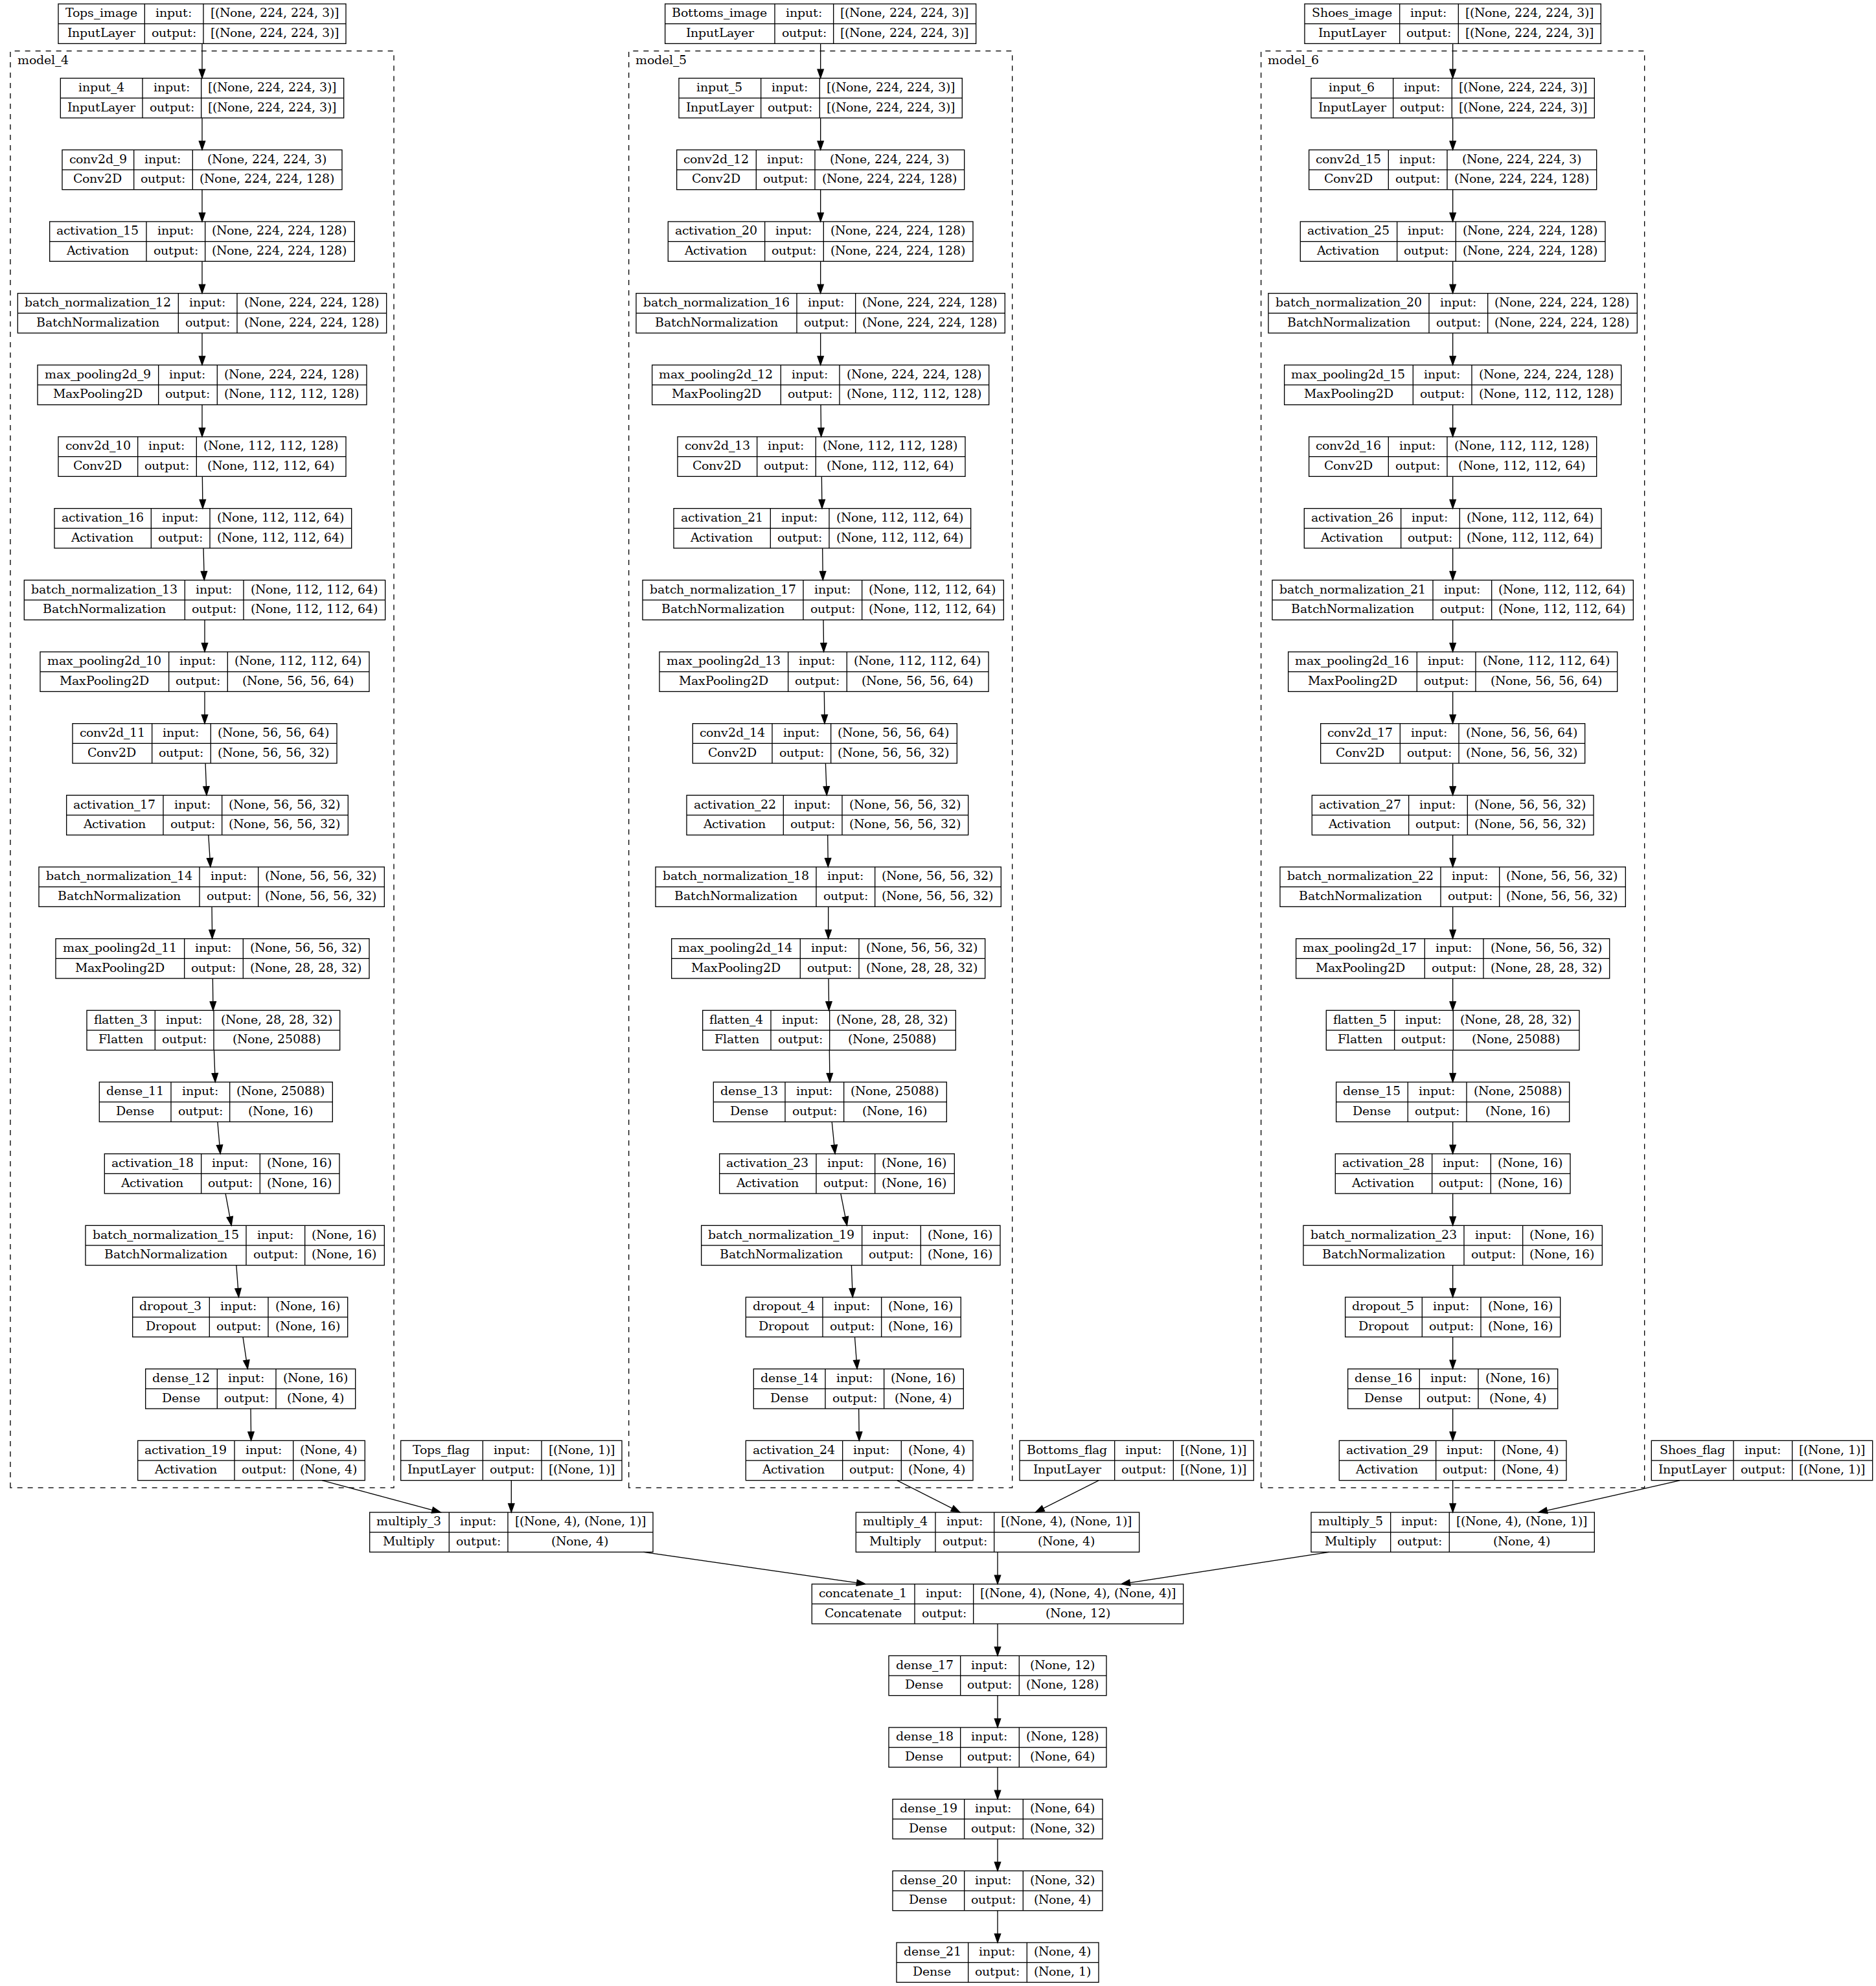

In [6]:
keras.utils.plot_model(model,show_shapes=True,expand_nested=True)


In [35]:
flags_Tops = np.ones((len(images_array_Tops), 1))
flags_Bottoms = np.ones((len(images_array_Bottoms), 1))
flags_Shoes = np.ones((len(images_array_Shoes), 1))

In [36]:
# Fit the model
history = model.fit(
    [images_array_Tops, flags_Tops, 
     images_array_Bottoms, flags_Bottoms, 
     images_array_Shoes, flags_Shoes],
    y_scaled,
    epochs=10,  # for example, 10 epochs
    batch_size=32,  # and a batch size of 32
    validation_split=0.2  # assuming you want to hold out 20% of the data for validation
)

Epoch 1/10


: 

In [28]:
flags_Tops = np.ones((len(images_array_Tops), 1))
flags_Bottoms = np.ones((len(images_array_Bottoms), 1))
flags_Shoes = np.ones((len(images_array_Shoes), 1))

 Making predictions

In [ ]:
# Assume you have three images for prediction
image_to_predict_tops = ... # Your preprocessed image array for Tops
image_to_predict_bottoms = ... # Your preprocessed image array for Bottoms
image_to_predict_shoes = ... # Your preprocessed image array for Shoes

In [33]:
# Flags indicating the presence of the categories
# If the category is present for the outfit, the flag is set to 1
# If the category is absent for the outfit, the flag is set to 0
# In this example, all three categories are present
flag_tops = np.array([[1]])
flag_bottoms = np.array([[1]])
flag_shoes = np.array([[1]])

In [ ]:
plt.imshow(images_array_Tops[0])

In [ ]:
plt.imshow(images_array_Bottoms[0])

In [ ]:
plt.imshow(images_array_Shoes[0])

In [ ]:
# Predict with the image arrays and corresponding flags
# Replace `dummy_array` and `dummy_flag` with actual data if present
predictions = model.predict(
    [
        np.array([image_to_predict_tops]), flag_tops,
        np.array([image_to_predict_bottoms]), flag_bottoms,
        np.array([image_to_predict_shoes]), flag_shoes,

    ]
)